<img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="500"/>

---


### ***Name***: Garv Sharma
### ***username***: gs1023
### ***CID***: 02486336


You can save this notebook in Colab by clicking `File` from the top menu, and then selecting `Download --> Download .ipynb`

Make sure that when you save your notebook you have all the cells executed and you can see the outputs (livelossplot graphs, etc)

## Justification of choice VAE/GAN

Explain in **two or three sentences** and/or a few **bullet points** why you have chosen to use a VAE or a GAN. There is no right or wrong choice, but the justification of the choice will be assessed.

your answer here

## Data preparation


1. Let's start with few imports important for our Model

In [1]:
!pip install livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image

import random
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


2. Let's load the training data and create a train_loader

**TRANSFORMER**

 1. we will keep our images 64*64 to get a better and good quality output image
 2. Making sure that our image is 64*64 square grid
 3. Converting the image to grayscale and tensor format

Why GAN over VAE?

1. GAN can produce better Image Quality, especially for the dataset of hands provided
2. GAN-generated images often exhibit greater sharpness and realism compared to those produced by VAEs.
3. he unique training mechanism of GANs, involving a generator and a discriminator in a competitive setup, inherently pushes the generator to produce more realistic images.
4. GANs offer a high degree of customizability and can be fine-tuned to produce very specific types of images,


In [17]:
# Define the location of the dataset
data_dir = '/content/gdrive/MyDrive/real_hands'

# Defining another different transformer for our Images

transform=transforms.Compose([
            transforms.Resize(64),
            transforms.CenterCrop(64), # Cut to square image
            transforms.Grayscale(), # Convert to grayscale
            transforms.ToTensor() # Transform from PIL image to Tensor
        ])

# Our CustomImageDataset will load the images and transform it to training dataset
class CustomImageDataset(Dataset):
    def __init__(self, path, transform):
        self.path = path
        self.files = os.listdir(path)
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img_path = os.path.join(self.path, img_name)
        with open(img_path, 'rb') as f:
            img = Image.open(f)
            img = img.convert('L')  # Convert to grayscale
        return self.transform(img)



In [6]:
from torch.utils.data import Dataset, DataLoader

# Instantiate the dataset
train_dataset = CustomImageDataset(data_dir, transform)

# Check the total number of images
print(f"Total number of images: {len(train_dataset)}")

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

# # Fetch a batch of images
images_batch = next(iter(train_loader))
print(f"Image batch shape: {images_batch.size()}")

Total number of images: 8000
Image batch shape: torch.Size([100, 1, 64, 64])


## Network design and implementation

3. We will create a class for our Generator and Discriminator

**Generator:**

1. The generator takes an input tensor of shape (batch_size, 100, 1, 1)
2. Layer 1: Expands the 100-dimensional input to a tensor with 1024 channels, using a ConvTranspose2d layer with a kernel size of 4, a stride of 1, and no padding. This significantly increases the depth while keeping the spatial dimension small.
3. Layer 2: Further upsamples the feature map to 512 channels with a kernel size of 4, stride of 2, and padding of 1. This layer doubles the spatial dimensions.
4. Layer 3: Continues the trend, upsampling to 256 channels.
5. Layer 4: Increases the spatial dimension again, reducing the channels to 128.
6. Applied after each ConvTranspose2d layer except the final output layer. Batch normalization stabilizes training by normalizing the output of each layer.
7. The Tanh activation function is applied at the end. Tanh scales the output to the range [-1, 1]

In [18]:
class Generator(nn.Module):
    """
    Takes a 100 element input vector and transforms
    it into an image with dimensions 64x64.
    Input is (batch_size, 100, 1, 1).
    """

    def __init__(self):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            # Hidden Layer 1
            nn.ConvTranspose2d(in_channels=100,
                               out_channels=1024,
                               kernel_size=4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(True),

            # Hidden Layer 2
            nn.ConvTranspose2d(in_channels=1024,
                               out_channels=512,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(True),

            # Hidden Layer 3
            nn.ConvTranspose2d(in_channels=512,
                               out_channels=256,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(True),

            # Hidden Layer 4
            nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(True),

            # Output Layer
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=1,   # Output channels = 1 for grayscale image
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.Tanh()  # Tanh activation for output
        )

    def forward(self, x):
        x = self.main(x)
        return x


**Discriminator:**

1. The discriminator takes an input tensor of shape (batch_size, n_ch, width, height) i.e. (batch_size, 1, 64, 64), indicating that it's designed to process 64x64 grayscale images.
2. First Layer: The input image is first processed by a convolutional layer with 64 filters, a kernel size of 4, a stride of 2, and padding of 1. This layer reduces the spatial dimensions to 32x32 while increasing the depth to 64.
3. Second Layer: Further processes the data with 128 filters, reducing the spatial dimensions to 16x16.
4. Third Layer: Continues the trend with 256 filters, reducing the spatial dimensions to 8x8.
5. Each convolutional layer is followed by a LeakyReLU activation function with a negative slope of 0.2, allowing a small gradient when the unit is inactive.
6. Applied after the second and third convolutional layers. Batch normalization helps stabilize training by normalizing the layer outputs.
7. After the last convolutional layer, adaptive average pooling is used to reduce the spatial dimensions to 1x1, effectively summarizing the features extracted from the image.
8. The flattened output from the convolutional layers is further processed by linear (fully connected) layers
9. he output of the final linear layer is passed through a sigmoid activation function. This scales the output to a range between 0 and 1, interpreting it as a probability (0 for fake, 1 for real).

In [19]:
class Discriminator(nn.Module):
    """
    A discriminator network with an additional convolution layer.
    Takes in a 64x64 image and produces a decision
    about whether that image is genuine or generated.
    Input is (batch_size x n_ch x width x height), in this case (batch, 1, 64, 64).
    Outputs (batch_size, 1, 1, 1) after flattening.
    """

    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),  # Output: (64 x 32 x 32)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),  # Output: (128 x 16 x 16)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1), # Output: (256 x 8 x 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AdaptiveAvgPool2d(1)  # Adaptive pooling to get (256 x 1 x 1)
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(256, 512),  # Process the 256 channels
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output to (batch_size, 256)
        x = self.linear_layers(x)
        return x.view(-1, 1, 1, 1)  # Reshape to (batch_size, 1, 1, 1)


## Training and evaluation loops

4. Create an Instance for Generator and Discriminator

In [20]:
G = Generator()
G(torch.randn(12, 100, 1, 1)).shape

torch.Size([12, 1, 64, 64])

In [21]:
# Confirm the discriminator produces a ruling given an image
# Map from (batch, 1, 64, 64) to (batch, 1, 1, 1)
D = Discriminator()
D(torch.randn(14, 1, 64, 64)).shape

torch.Size([14, 1, 1, 1])

In [22]:
# Move everything to the GPU for training
gpu = torch.device(0)
G = G.to(gpu)
D = D.to(gpu)

5. Creating a training function for generator and Discriminator training.

In [23]:
def D_train(x):
    # Reset gradients
    D.zero_grad()

    # Train with real data
    real_data = Variable(x).to(gpu)
    real_labels = Variable(torch.ones(real_data.size(0), 1, 1, 1)).to(gpu)
    real_output = D(real_data)
    d_loss_real = compute_loss(real_output, real_labels)

    # Train with fake data
    noise = Variable(torch.randn(real_data.size(0), 100, 1, 1)).to(gpu)
    fake_data = G(noise)
    fake_labels = Variable(torch.zeros(real_data.size(0), 1, 1, 1)).to(gpu)
    fake_output = D(fake_data.detach())
    d_loss_fake = compute_loss(fake_output, fake_labels)

    # Backpropagation
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    optimizer_d.step()

    return d_loss.item()


In [24]:
def G_train(x):
    # Reset gradients
    G.zero_grad()

    # Generate fake data
    noise = Variable(torch.randn(x.size(0), 100, 1, 1)).to(gpu)
    fake_data = G(noise)

    # Train with fake data
    labels = Variable(torch.ones(x.size(0), 1, 1, 1)).to(gpu)
    output = D(fake_data)
    g_loss = compute_loss(output, labels)

    # Backpropagation
    g_loss.backward()
    optimizer_g.step()

    return g_loss.item()

## Network training
Use the best hyperparameters and network design here (and justify briefly your choices, linking them to the `yourusername_DLcw1_hypertune.ipynb` notebook.

Show loss evolution with livelossplot or any other graphic visualisation tool of your choice

**Setting up Hyperparameters, these are chosen after multiple different hyperparameters tuning, does in testing notebook.**

1. Batch_size = 100 and z_dim = 100
We tried with reduced batch size/z_dim as well but the output of our generator gave a very high loss. So, sticking to the default and optimal condition.

2. Optimizer:

  2.1 We tried several optimizer conditions with different conditions (refer to the hyperparameter notbook for the same)

  2.2. For lr = 0.0001, the Generator performs well but the Generator is dispurted after 30 epochs causing the loss to increase as we go along.
  2.3. We tried lr = 0.0001 for discriminator and lr = 0.0002 for generator to improve the network, but faced same kind of problem after 100 epochs.(refer to the hyperparameter notbook for the same)

  2.3 We tried to train our netwook without betas=(0.5, 0.999), which was giving very high loss.

3. Loss function(criterion): BCE loss is well-suited for the kind of binary decision-making required in GANs and provides a stable and effective learning signal for both the generator and the discriminator during training.

4. Epochs:
  We kept 300 epochs to looks for network performance for longer period due to complex nature of network.




In [27]:
from torch import optim

# Choose a loss function. Binary Cross Entropy Loss.
compute_loss = nn.BCELoss()

# Specify training details
n_epochs = 300
batch_size = 100
z_dim = 100


# Create an optimizer to update the weights of each network
optimizer_d = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_g = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# a starting latent space of 100 is a standard choice
test_noise = torch.randn((8, z_dim, 1, 1)).to(gpu)


In [ ]:
import numpy as np

n_epochs = 300
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epochs+1):
    D_losses, G_losses = [], []
    logs = {}
    for i, x in enumerate(train_loader):
        D_loss = D_train(x)
        G_loss = G_train(x)
        logs['D_Loss'] = D_loss
        logs['G_Loss'] = G_loss
        D_losses.append(D_loss)
        G_losses.append(G_loss)

    liveloss.update(logs)
    liveloss.draw()

    epoch_D_loss = np.mean(D_losses)
    epoch_G_loss = np.mean(G_losses)
    print(f"Epoch {epoch}/{n_epochs}, D Loss: {epoch_D_loss}, G Loss: {epoch_G_loss}")

    # Save model if G_loss is less than D_loss
    if epoch_G_loss < epoch_D_loss:
        torch.save(G.state_dict(), f"/content/gdrive/MyDrive/my_GAN_{epoch}.pth")

    # Save model every 20 epochs
    if epoch % 30 == 0:
        torch.save(G.state_dict(), f"/content/gdrive/MyDrive/final_GAN_epoch_{epoch}.pth")

We are running the code below to create a liveloss plot, this plot is already generated in the hyperparameter tuning notebook and we are using the same plot here to reduce the redundency of training model again

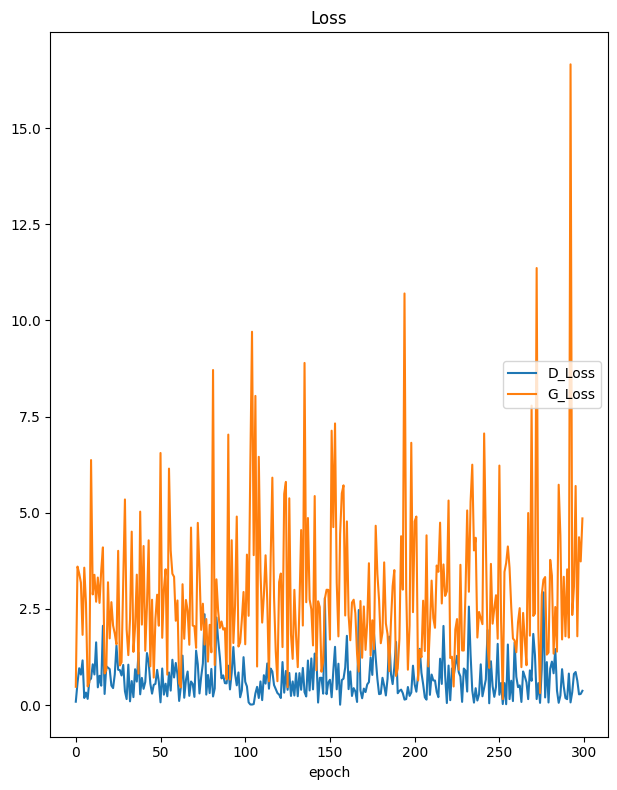

Loss
D_Loss           	 (min:    0.008, max:    2.930, cur:    0.369)

G_Loss           	 (min:    0.153, max:   16.657, cur:    4.852)

Epoch 300/300, D Loss: 0.5035349503159523, G Loss: 3.92806844264268

**Result:** We can observe the during the epoch range around 270 our generator is performing really well and the losses of both are comparable.


## Generate 300 new samples with your trained network

Creating the generated samples for visualization for epoch 270, the model is already available

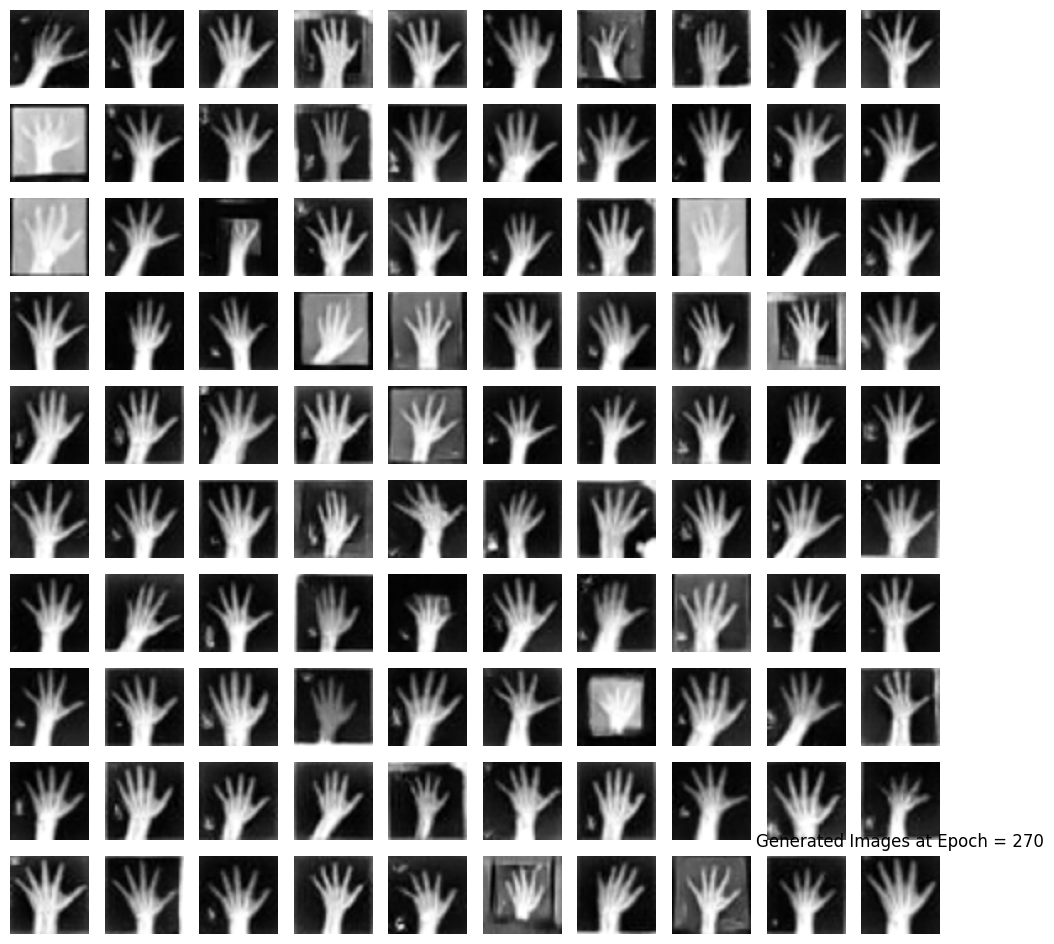

In [29]:
# from torchvision.utils import save_image
set_seed(42)

G = Generator()
epoch = 270  # Model after 270 epochs
# Assuming G is defined and has the same architecture as during training
G.load_state_dict(torch.load(f"/content/gdrive/MyDrive/final_GAN_epoch_270.pth"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G.to(device)

batch_size = 100  # Set to your desired batch size
z_dim = 100       # Set to your generator's noise dimension

with torch.no_grad():
    test_z = torch.randn(z_dim, batch_size, 1, 1).to(device)
    generated = G(test_z)

    # Optionally save the generated images
    # save_image(generated.view(generated.size(0), 1, 28, 28), './sample.png')

fig, axarr = plt.subplots(10, 10, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 64, 64).cpu()):
    ax.imshow(img, cmap="gray")
    ax.axis('off')
plt.title(f'Generated Images at Epoch = {epoch:03d}')
plt.show()

## Save the 300 generated samples as `.jpeg` files
The format of the saved samples should be `.jpeg`, and the names of the files should be:
- `yourusername_VAE001.jpeg`, `yourusername_VAE002.jpeg`, ... , `yourusername_VAE300.jpeg`

or

- - `yourusername_GAN001.jpeg`, `yourusername_GAN002.jpeg`, ... , `yourusername_GAN300.jpeg`

You can save your samples in your Google Drive or your local machine and then copy them to the repo where you will submit the answer.

The below code will save 300 images of hands in the required format in our connect drive.

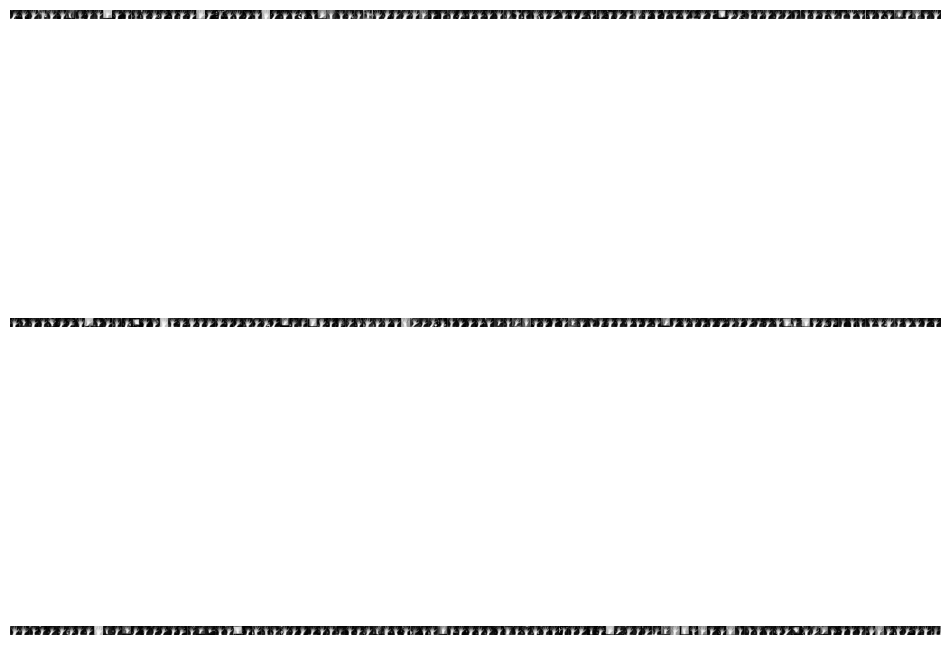

In [30]:
import os
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from torchvision import transforms

# Set your seed for reproducibility
set_seed(42)

# Load the Generator
G = Generator()
epoch = 270  # Model after 100 epochs
G.load_state_dict(torch.load(f"/content/gdrive/MyDrive/final_GAN_epoch_270.pth"))
G.to(device)

# Directory where the images will be saved
save_dir = "/content/gdrive/MyDrive/GAN_hands"
os.makedirs(save_dir, exist_ok=True)

# Generate images
batch_size = 100  # Set to your desired batch size
z_dim = 100      # Set to your generator's noise dimension
n_batches = 3   # Calculate to generate 300 images in total

fig, axarr = plt.subplots(n_batches, batch_size, figsize=(12, 12))
for i in range(n_batches):
    with torch.no_grad():
        test_z = torch.randn(batch_size, z_dim, 1, 1).to(device)
        generated = G(test_z)
        generated = generated.view(generated.size(0), 1, 64, 64)  # Reshape if necessary

        for j, img in enumerate(generated):
            img_index = i * batch_size + j + 1

            # Save the image
            save_image(img, os.path.join(save_dir, f"gs1023_{img_index:03d}.jpeg"))

            # Display the image
            ax = axarr[i, j]
            img = transforms.ToPILImage()(img.cpu().squeeze(0))
            ax.imshow(img, cmap='gray')
            ax.axis('off')

            if img_index == 300:  # Stop if 300 images are generated
                break

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
